# Dimension reduction

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import *


When dealing with datasets with a large number of features, visualisation techniques reach their limits.
Plotting a dataset with respect to two features will only bring a partial, and possibly biaised, view of the dataset.
One can observe behaviours that can seem contradictory, like shadow observations shown in the following picture.

<img src="../../figures/reddim_pointview.png" alt="drawing" width="500"/>

Dimension reduction is a set of techniques which aim at compressing most of the information contained in the dataset into a new representation of lower dimension.
If a user wish to have an understanding of distances between instances (for example to identify clusters), the dataset can be compressed into two dimensions.
With two dimensions, it is then easy to plot the instances into a scatter plot and use the power of pattern detection of our brain to get insight from the data.
Furthermore, many machine learning algorihtms perform poorly when applied on many variables with diluted information.
Dimension reduction can then be a processing tool to transform a large diluted dataset into a smaller and denser one.

There exists many algorithms for dimension reduction, each with their own specificity.
This course aims at presenting only one algorithm from each broad class of techniques.
The student is invited to watch this [youtube video](https://www.youtube.com/watch?v=9iol3Lk6kyU&t=762s) to get a sense of the possible variations of the techniques presented.


## PCA

Principal component analysis (PCA) is clearly the most famous algorithm for dimension reduction.
While it is also probably the oldest, it remains a must have tool : it is well studied, fast, and simple enough to give a basic understanding of the dataset.
Given the distributions of instances in the N-dimensional space of the features (N can be quite large), PCA looks for a rotation of the space in order to have axes which separate best the instances.


### Description

The strategy of PCA is to find an arbitrary axis in the high dimensional space and to project the data on this axis.
Each instance is now represented by a single number : its projection onto this axis.
Let's look at a random dataset to visualise this step.

In [ ]:
# create random 2D data of mean 0 and std 1
np.random.seed(43)
dummy = np.random.multivariate_normal([0, 0], np.eye(2), size=200)
dummy[:5]

array([[ 0.25739993, -0.90848143],
       [-0.37850311, -0.5349156 ],
       [ 0.85807335, -0.41300998],
       [ 0.49818858,  2.01019925],
       [ 1.26286154, -0.43921486]])

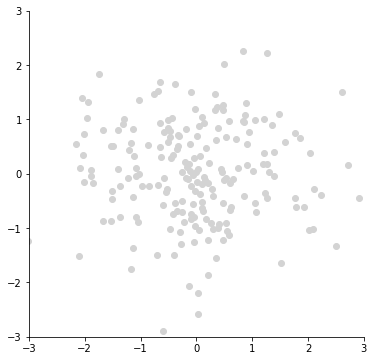

In [ ]:
# Make a scatter plot of the data
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dummy[:,0], dummy[:,1], color='lightgrey')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3);

Let's choose a random axis of norm 1.

In [ ]:
axis = np.array([1, -2])
# normalize the axis
axis = axis / np.linalg.norm(axis)
axis

array([ 0.4472136 , -0.89442719])

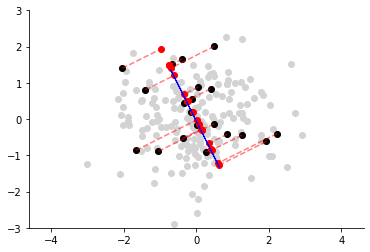

In [ ]:
from src.visualization.utils import *
show_projection(dummy, axis, dummy[:20], min_axis=-3, max_axis=3)

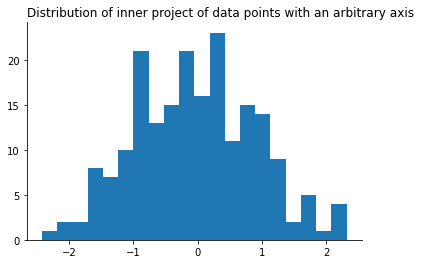

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.inner(dummy, axis), bins=20)
ax.set_title("Distribution of inner project of data points with an arbitrary axis", loc='left');

Now that we know how to create an arbitrary reduction, let's look at how to create a good reduction.

__How can we define if an axis is a good axis to project on?__

The objective ot reduction technique is to obtain a small number of variable for which the dataset structure is conserved.
Said differently, we want that points that were ___close___ together in high dimension remain close in small dimension.
Similarly, points that were distant should remain distant.

Let's look at 

In [ ]:
dummy = np.random.multivariate_normal([0, 0], [[1, 0.7], [0.7, 1]], size=200)

In [ ]:
axis = np.array([1, -1])
# normalize the axis
axis = axis / np.linalg.norm(axis)
axis

array([ 0.70710678, -0.70710678])

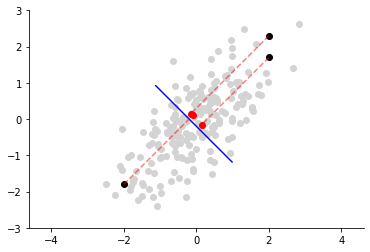

In [ ]:
X = np.array([[2, 2.3], [-2, -1.8], [2, 1.7]])
show_projection(dummy, axis, X, min_axis=-3, max_axis=3)

With the proposed projection, the two extremal points end up very close to each other in term of projection.
They actually end up much closer than the two internal points which are initially much closer.
We have to find an axis which will reduce this situation to a minimum.

The inital data have a natural spread in the phase space.
A good projection axis should maintain a similar spread so that data points are not compressed.
The objective is then to __maximise the variance of the projection__.
PCA will __try__ various axes and select the one which creates the largest variance.

### Computation

Let's consider an arbitrary projection axis, defined by its unit direction vector $\vec{w} = (w_1,w_2)$.
For each instance, its projection onto this axis will take the form.


$$\hat{x_i} = \vec{x}_i . \vec{w} $$

Let's assume, without loss of generality, that both initial features have a zero mean and unit standard deviation.
Then the variance of the projections takes the form.

$$V(\hat{x})  = \sum (\vec{x} . \vec{w})^2 = \sum ( x_{1i}w_1 + x_{2i}w_2)^2$$

Which takes the following form in matrix notation.
\begin{equation}
  \begin{split}
    V(\hat{x}) & = || X \dot w ||^2 \\
    & = w^TX^TXw \\
  \end{split}
\end{equation}

Here the term $X^TX$ corresponds to the correlation matrix of $X$.
Because this is a semi positive definite matrix, it can be shown that the largest variance is the largest  eigen value of the correlation matrix.
With diagonalisation of the correlation matrix, one can then compute the projection axis which transform our 2D dataset into a 1D dataset with maximal variance.
If we wish to get more than one dimension, one can simply take the eigen vectors with decreasing eigen value.
[This paper](https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/) proposes a more in-depth explanation of PCA.

### Usage


We will consider here a subset of the [breast cancer dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) provided by sklearn.
We wish to reduce the information contained in this dataset into a single dimension.
We will consider at first only a couple of variable for pedagogical purposes.

The [sklearn](https://www.youtube.com/watch?v=0Lt9w-BxKFQ) library already packages the PCA algorithm under its [standard API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
raw = pd.read_parquet(ROOTDIR / 'data' / 'interim' / 'breast_cancer.parquet')
print(raw.shape)
raw.head()

(569, 31)


diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  radius_worst  \
id                                            ...                 
842302                0.14710         0.2419  ...         25.38   
842517                0.07017         0.1812  ...         24.99   
84300903              0.12790         0.2069  ...         23.57   
84348301              0.10520         0.2597  ...         14.91   
84358402              0.10430         0.1809  ...         22.54   

          texture_worst  perimeter_worst  area_worst  smoothness_worst  \
id                                                                       
842302            17.33           184.60      2019.0            0.1622   
842517            23.41           158.80      1956.0            0.1238   
84300903          25.53           152.50      1709.0            0.1444   
84348301          26.50            98.87       567.7            0.2098   
84358402          16.67           152.20      1575.0            0.1374   

          compactness_worst  concavity_worst  concave points_worst  \
id                                                                   
842302               0.6656           0.7119                0.2654   
842517               0.1866           0.2416                0.1860   
84300903             0.4245           0.4504                0.2430   
84348301             0.8663           0.6869                0.2575   
84358402             0.2050           0.4000                0.1625   

          symmetry_worst  fractal_dimension_worst  
id                                                 
842302            0.4601                  0.11890  
842517            0.2750                  0.08902  
84300903          0.3613                  0.08758  
84348301          0.6638                  0.17300  
84358402          0.2364                  0.07678  

[5 rows x 31 columns]

In [ ]:
from sklearn.decomposition import PCA
transfo = PCA(2) # only take the firsts two eigen value

# Compute and save eigen values
transfo.fit(raw[['radius_mean','perimeter_mean']])

projection = transfo.transform(raw[['radius_mean','perimeter_mean']])

In [ ]:
# best axis is stored in the components attribute
transfo.components_[0]

array([0.14323798, 0.98968828])

In [ ]:
# The amount of variance per axis is save in an attribute
transfo.explained_variance_

array([6.02807278e+02, 5.21213668e-02])

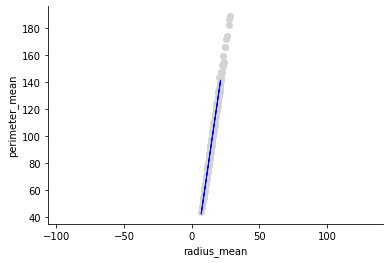

In [ ]:
show_projection(raw[['radius_mean','perimeter_mean']].values, transfo.components_[0], scale=100,
               xlabel='radius_mean', ylabel='perimeter_mean')

### Scaling problem
In this dataset, we observe that best projection axis is largely dominated by the perimeter_mean axis.
If we have two variables with higly different variances, it is obvious that porjecting on the axis with the largest variances does most of the work.
Then we can take alittle of the second axis to get a little more variance.
As a result, the contribution of the second axis higly depends on the noise of the first axis.

In [ ]:
np.random.seed(65)
np.random.normal(size=1000).std()

0.9968236334495252

In practice it is always better to normalise variables so that all variables have variances of 1.
Then, it really the interactions between variables which will play a role in improving the variance of the projections.

In [ ]:
from sklearn.preprocessing import StandardScaler

#transform feature to have mean 0 and std 1
scaler = StandardScaler()
scaled = scaler.fit_transform(raw[['radius_mean','perimeter_mean']].values)

from sklearn.decomposition import PCA
transfo = PCA(2)

# Compute and save eigen values
projection = transfo.fit_transform(scaled)

In [ ]:
# best axis is stored in the components attribute
transfo.components_[0]

array([0.70710678, 0.70710678])

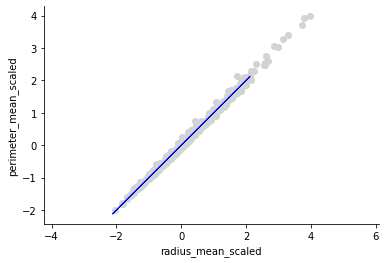

In [ ]:
show_projection(scaled, transfo.components_[0], scale=6,
               xlabel='radius_mean_scaled', ylabel='perimeter_mean_scaled')

# Non linearities

PCA relies on the Pearson correlation matrix, hence on linear correlation.
Hence this technique may not be appropriate for data with more subtle correlations.


In [ ]:
raw['exp_perimeter'] = 1-np.exp(-raw.perimeter_mean/30)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True)
scaled = scaler.fit_transform(raw[['radius_mean', 'exp_perimeter']])
pca_scaled = PCA(2)
transformed = pca_scaled.fit_transform(scaled)
pca_scaled.components_[0]

array([-0.70710678, -0.70710678])

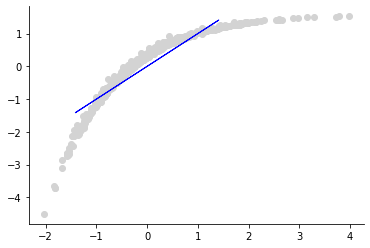

In [ ]:
fig, ax = plt.subplots()
plt.scatter(scaled[:,0], scaled[:,1], color='lightgrey')

V = pca_scaled.components_
m = scaled.mean(0) - V[0]*2
ax.arrow(*list(m), *list(V[0]*4), color='blue');

In the case of our exponential transformation, projections of extreme points are further away than they should be,
and central points are closer than they should be.
But overall, the ordering of the distances is roughly maintained.

Let's now look at an even more non linear transformation.

In [ ]:
raw['cos_perimeter'] = np.cos((raw.perimeter_mean-20)/90*2*np.pi)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(raw[['radius_mean', 'cos_perimeter']].values)

In [ ]:
pca_scaled = PCA(2)
transformed = pca_scaled.fit_transform(scaled)

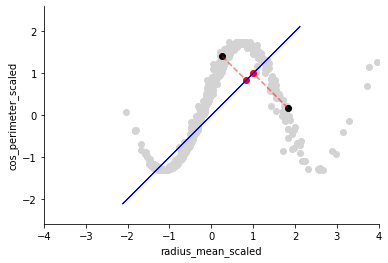

In [ ]:
show_projection(scaled, pca_scaled.components_[0], scaled[[94, 1]] ,scale=6,
                min_axis=-4, max_axis=4,
               xlabel='radius_mean_scaled', ylabel='cos_perimeter_scaled')

Here, two points that are far away in the manifold are projected closer than more related points.
It is then important to linearise variables.
Think of the problem in the opposite way than we have created it.
Suppose that out initial value is ```cos_perimeter``` and we have the correct formula to transform it into ```perimeter_mean```.
Then applying PCA to the linear variable is similar to performing a projection on the following non linear line, which better fit the underlying data structure.

In [ ]:
from sklearn.decomposition import PCA
transfo = PCA(2) # only take the first eigen value

# Compute and save eigen values
transfo.fit(raw[['radius_mean','perimeter_mean']])

axis = (raw[['radius_mean','perimeter_mean']].mean(0).values.reshape(1, -1) 
        + np.linspace(-50, 50, 201).reshape(-1, 1) * transfo.components_[0].reshape(1, -1))
axis[:,1] = np.cos((axis[:,1]-20)/90*2*np.pi)

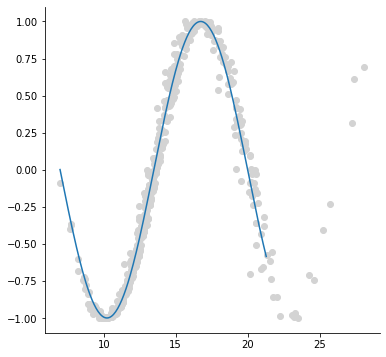

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(raw.radius_mean, raw.cos_perimeter, color='lightgrey')
ax.plot(axis[:,0], axis[:,1]);

### Statistics

PCA, like most of the algorithms, will always give results, even in situation were the results are not sensible.

First, PCA is sensitive to statistical fluctuations.
It uses the correlation matrix to compute the best projection axis.
However, this correlation matrix is subject to statistical fluctuations.
Hence, measuring the correlation in the data will give results more or less different to what the true underlying correlation really is.
In the following, we create a random dataset from a known unit correlation matrix.
In theory, all correlations between differnt variables should be null.
However we observe, at different levels, that the measured correlation matrix is different to the theoretical one.

In [ ]:
ndim = 3
np.random.seed(87)
corr = np.eye(ndim)
data = np.random.multivariate_normal(np.zeros(ndim), corr, size=100000)

In [ ]:
pca = PCA(3).fit(data)
pca.components_, pca.explained_variance_

(array([[ 0.47666367,  0.85299221,  0.21259361],
        [-0.70403348,  0.51523443, -0.48874364],
        [ 0.52643007, -0.08329332, -0.8461286 ]]),
 array([1.00691276, 1.00071978, 0.98810648]))

The components identified by PCA are not trivial, so we may think, "there is value in combining those variables".
But when we look at the variance of the data in each direction we see that basically all directions are equivalent (and equivalent with the natural directions).
Then there is no interest in reducing the dimension of the data.

Then, __why does PCA gives us meaningless results?__

Because of statistical fluctuations, the experimental correlation matrix (shown below) is different than the real correlation matrix that we input.
So there exists an axis with a tiny bit more variance than other ones, and PCA has found it.
With infinite data, those matrices would be identical.

In [ ]:
corr_exp = np.corrcoef(data.T)
corr_exp

array([[1.00000000e+00, 3.06531583e-03, 6.27540691e-03],
       [3.06531583e-03, 1.00000000e+00, 2.34438669e-04],
       [6.27540691e-03, 2.34438669e-04, 1.00000000e+00]])

Here we had a sufficiently large amount of data so that difference is minimal : 
we still see that projections axes are meaningless.
But with a lower amount of data, the statistical fluctuations may modify more severely the correlation matrix.
Then PCA will be able to find "really meaningful" axes, purely by exploiting fluctuations.
As a result, even the observation of the explained variance would not indicate an issue.
Let's try with only 30 data points.

In [ ]:
np.corrcoef(data[:30].T)

array([[ 1.        , -0.17144718, -0.07913199],
       [-0.17144718,  1.        ,  0.20980166],
       [-0.07913199,  0.20980166,  1.        ]])

We already see that the correlation matrix deviates more from the theoretical one.

In [ ]:
pca = PCA(3).fit(data[:30])
pca.components_, pca.explained_variance_

(array([[-0.80686358,  0.38319272,  0.4495937 ],
        [-0.55536156, -0.23262711, -0.79840977],
        [ 0.20135713,  0.89389483, -0.40050885]]),
 array([1.31004499, 0.99327248, 0.63657098]))

Again, the measured axes are not trivial.
But we see that the variances start to show a difference.
It is then more ambiguous to determine the pertinence of the reduction.

[Multiple techniques](http://www.iaees.org/publications/journals/ces/articles/2012-2(2)/permutation-tests-to-estimate-significances.pdf)
exists to evaluate the significance of the extracted eigen vectors.
But before diving into highly analytical process, the analyst must always take some time to identify if the conditions are set so that the result will be meaningful.

### Summary

* PCA projects data on the eigen vectors of the correlation matrix.
* If data are in differents scales, it should be normalised.
* If features have a highly non-linear relationship, it is better to transform them beforehand.


## UMAP

[UMAP](https://www.youtube.com/watch?v=nq6iPZVUxZU) is a technique developped in 2018.
It belongs to another class of dimension reduction techniques : graph algorithms.

This strategy relies on measuring the distance between each instance in the high dimensional space.
Then one need to find coordinates in the low dimensional space for each point such that the distance matrix between each point is similar in both space.
In practice, for computational purposes, algorithms do not use the full distance matrix but a subset. 
Each point is linked only to its closest neighbours.
As a result, the distance between distant points is estimated like we estimate an itinerary : by measuring the road distance going from village to village instead of flying distance.

Consider the MNIST dataset, containing 28x28 images of hand written digits.
If we consider each pixel as a features, we can compute the distance between images.
All 7 will be close to each other because white parts should roughly match.

<img src="../../figures/mnist.png" alt="drawing" width="500"/>

Forcing the distance matrix between 28x28 dimensional space and the 2 dimensional space to be similar will force similar digits to be close to each other.

<img src="../../figures/mnist_umap.png" alt="drawing" width="500"/>

There exist many different techniques to match the two distance matrices.
Here we will describe the latest one, UMAP.
The reader may have also heard of [T-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf) which is also quite popular.


### Description

The starting point of the algorithm is a math theorem, called nerve theorem, that states that there is no loss of information when describing a manifold in term of neighbourhood graph of points in this manifold.
This theorems then justifies the techniques of neigbourhood graphs for dimension reduction.
In practice, one can create a graph by taking the data points as vertices, and adding edges between vertices which are close to each other.
However, most of the time the data is not uniformly distributed in the manifold.
There are regions of the graph which are heavily linked and others totally disconnected, not because of the manifold, but because of the sampling of the data on it.
In order to correct that, the notion of distance in the manifold will be broken into many local distances.
In particular, each point will consider its closest neighbour to be at distance 1, whatever its distance in the real space.
Because of all the local distances, the distance between two points is dependent on the point of reference.
Then the two distances between two points (depending on the point of reference) are combined to define a single distance between the points.
Finally we have our graph were each point is linked to its neigbhours proportionally to their relative distance.

Then imagine a random embedding in lower dimension for each point.
We can create another neighbour graph in this lower dimension space.
Then, we can optimise the position of each point in this low dimensional space so that distance in high and low dimension are the closest possible.
UMAP minimises the cross entropy loss of the weights of corresponding edges between the two graphs.
In this minimisation, two terms will fight each other.
First, an attractive term ensure that the structure of closely related points remains the same.
Inversely, a repulsive term ensures that far away points remain far away in the embedding.
As a result, two independent clusters should not overlap each other.

<img src="../../figures/umap_connectivity.png" alt="drawing" width="500"/>


### Properties
Like PCA (and unlike T-SNE), UMAP creates a transformation of the inital space into the lower dimensional space.
Once trained, this transformation is still available.
As a result, UMAP can be used to compute the reduced embedding of a new point which was not part of the training dataset.
Experiments have shown the stability of the transformation on unseen data.

Experiments have been performed to compare the training time of UMAP agains T-SNE for large datasets.
It turns out that UMAP scales a lot better.

UMAP can effectively work with heterogeneous data.
As long as the user is able to create a notion of distance between the points, the algorithm will be able to compute an embedding.
This means the distance between instances could be the combination of euclidian distance between continuous values, cosine distance, levenstein distance between string, one hot distance between cateogrical variables, etc ...



### Parameters 

UMAP has many parameters that can be used to tune the results or to apply the algorithm to different use cases.
The library provides an excellent [documentation](https://umap-learn.readthedocs.io/en/latest/) of those less standard usages.

#### n_components
This parameter dictates how many dimensions must the final space have.
UMAP can be effectively applied to any dimension (unlike T-SNE which is limited to 2 or 3 dimensions).
It can even be used with an output dimension equal to the input one.
In this case, it will create new features which better represent the notion of distance between instances.

#### random_state

UMAP uses stochastic gradient descent to minimise the cross entropy between the inital and embedded graphs.
As a result, applying many times UMAP on the same data may give significantly different results.
In order to give reproducibilty to results, UMAP provides a ```random_state``` parameters (like in sklearn) which ensure to always get the same result.

#### n_neighbors
The second major parameters is ```n_neighbors```.
It controls how many neighbors are actually considered when constructing the neighbourhood graph.
This parameter controls the execution time, higher ```n_neighbors``` means more edges to compare, but also has a major impact on the final result.
Indeed, with a low number of neighbors the minimisation will mostly focus on having fine grained structures right at the cost of larger scale structure.
This leads to having many small blobs scatterd around the embedding.

#### min_dist
This control how close non-indentical instances can be in the final embedding.
A low value will allow UMAP to squeeze closely related points into dense regions.
Conversely, a large value will force a larger spread of the data.
The following shows the combined impact of the number of neigbours and the minimum distance on the embedding.

<img src="../../figures/lel2018umap_f1.png" alt="drawing" width="500"/>



## Non linearities

The UMAP algorithm has the power to uncover highly non linear relations between the variables of the dataset.
This is because it does not look at the full structure of the dataset, like PCA does.
It only looks at points which are very close.

Let's look how UMAP deals with the two cases of non-linearity proposed to the PCA.

### exponential

Here we look again at the relation betwee, radius and the exponential of the perimeter.
In the graph, we color coded each point depending on the radius.
Thanks to that, we will be able to identify were are each point sent in a one dimensional embedding.

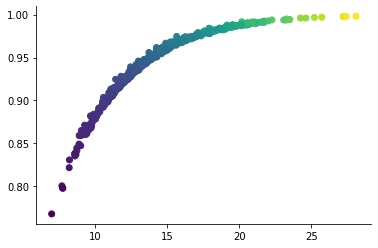

In [ ]:
fig, ax = plt.subplots()
ax.scatter(raw.radius_mean, raw.exp_perimeter, c=raw.perimeter_mean);

In this graph, the x axis is simply the index of each instance of the dataset, from 0 to 569.
As such, there is no meaning to the x axis, except to spread a 1D distribution on a 2D plane.
We observe that all the light colors are located at the bottom of the plot, while the darker points at the top.
UMAP has understood that points belong to some kind of a line and respected this topology in its embedding.

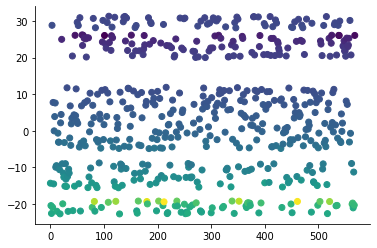

In [ ]:
from umap import UMAP
scaler = StandardScaler(with_mean=True)
scaled = scaler.fit_transform(raw[['radius_mean', 'exp_perimeter']])
red = UMAP(n_neighbors=30, min_dist=0.1, n_components=1, random_state=20)
transformed = red.fit_transform(scaled)
fig, ax = plt.subplots()
ax.scatter(range(len(transformed)), transformed.ravel(), c=raw.perimeter_mean);

### cosinus

We can try to reproduce this result with the cosine transformation, which is much more non-linear than the exponential one.

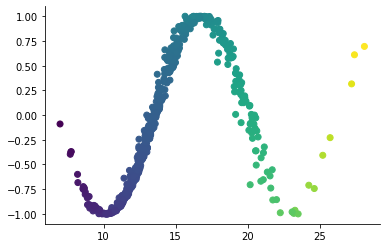

In [ ]:
fig, ax = plt.subplots()
ax.scatter(raw.radius_mean, raw.cos_perimeter, c=raw.perimeter_mean);

Even with a cosine transformation, UMAP was able to understand that the data lied on a single line, and respected this structure when creating its embedding.
It seems that the top block is reversed compared to what might be expected, because of the low density of points in the light green region.
Indeed, when looking for the 20 closest neighbors in the initial 2D space, UMAP will find points on the other side of the curve instead of following the cosine shape.
We can see that it doesn't seem to be the case between dark green and blue, because of higher density.

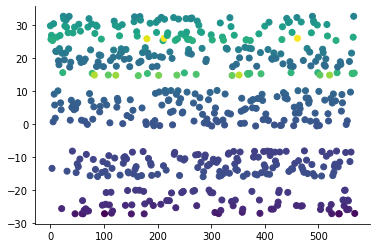

In [ ]:
from umap import UMAP
scaler = StandardScaler(with_mean=True)
scaled = scaler.fit_transform(raw[['radius_mean', 'cos_perimeter']])
red = UMAP(n_neighbors=20, min_dist=0.1, n_components=1, random_state=20)
transformed = red.fit_transform(scaled)
fig, ax = plt.subplots()
ax.scatter(range(len(transformed)), transformed.ravel(), c=raw.perimeter_mean);

## Metric

Like for many algorithm, the notion of metric is essential in UMAP.
The metric will define which instances are closer, hence modifying the global structure of the dataset.
By default, UMAP uses the euclidian distance in both the initial and embedding space.
However, if dealing with worldwide GPS coordinates the euclidian metric would not have much sense.
It would have no sense to define the distance between Paris and San Francisco with the euclidian distance of their coordinates.
The curvature of the earth should be taken into account.
UMAP proposes a large selection of metrics to use in the initial space but also allows the use of custom metrics.
For example, one can create a metric which combines geospatial spatial data with standard continuous values, categorical data and text.
As long as the user can define a function with takes two arbitrary data structures and return a distance metric, UMAP can use it to perform the embedding.

The choice of a metric is not simply in the mathematical formula.
Even if the analyst keeps the standard euclidian distance, there is still the question of the variables to take into account and wether or not those variables are transformed.
Those choices may have a profound effect and may lead to extremely different results.

In [ ]:
test = raw[['texture_mean', 'perimeter_mean', 'symmetry_mean']].iloc[:10]
test

texture_mean  perimeter_mean  symmetry_mean
id                                                   
842302           10.38          122.80         0.2419
842517           17.77          132.90         0.1812
84300903         21.25          130.00         0.2069
84348301         20.38           77.58         0.2597
84358402         14.34          135.10         0.1809
843786           15.70           82.57         0.2087
844359           19.98          119.60         0.1794
84458202         20.83           90.20         0.2196
844981           21.82           87.50         0.2350
84501001         24.04           83.97         0.2030

Let's look at the distance between the first two lines of the previous dataset.

$$d^2 = (17-10)^2 + (132-122)^2 + (0.24 - 0.18)^2 = 150$$

$$d = \sqrt{150} = 12.5$$

Here we realise that the relative distance of two instances with respect to ```symmetry_mean``` will never bring a significative contribution to the total distance.
Effectively, it is like ```symmetry_mean``` was not integrated in the dataset.

Let's look at what happens if we rescale all the columns to have mean 0 and standard deviation of 1.
The last column will be expanded while the first two will be shrunk. 

In [ ]:
scaled = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)
scaled

texture_mean  perimeter_mean  symmetry_mean
0     -2.122203        0.737931       1.156456
1     -0.225592        1.187508      -1.162569
2      0.667535        1.058422      -0.180708
3      0.444254       -1.274931       1.836499
4     -1.105886        1.285436      -1.174030
5     -0.756848       -1.052813      -0.111940
6      0.341595        0.595490      -1.231337
7      0.559744       -0.713182       0.304491
8      0.813823       -0.833366       0.892844
9      1.383577       -0.990495      -0.329706

With unscaled data, it was ```perimeter_mean``` which was the major contributor to the distance between the first two elements.
But relatively speaking, the distance of 10 for this variable was not much.
Instead, we see that those two instances are very separated with respect to the first and last columns.

Let's see how the distribution of distances changes.
With the following code, we can compute the pairwise distance between the points, and plot it in a heatmap.

In [ ]:
# create a matrix of pairwise distance between each instance
from scipy.spatial.distance import cdist
dists = cdist(test, test)
dists

array([[ 0.        , 12.51502235, 13.03833291, 46.31251145, 12.92189309,
        40.58024645, 10.11948152, 34.2339451 , 37.10746081, 41.16267743],
       [12.51502235,  0.        ,  4.53001771, 55.38159137,  4.07491105,
        50.37255757, 13.48236267, 42.80952084, 45.58031806, 49.33009503],
       [13.03833291,  4.53001771,  0.        , 52.42724566,  8.58829296,
        47.75361142, 10.47729241, 39.80221804, 42.50383147, 46.11447728],
       [46.31251145, 55.38159137, 52.42724566,  0.        , 57.83630529,
         6.84142536, 42.02198054, 12.6280841 , 10.0240017 ,  7.36416424],
       [12.92189309,  4.07491105,  8.58829296, 57.83630529,  0.        ,
        52.54760958, 16.49422936, 45.36663529, 48.18416054, 52.04197718],
       [40.58024645, 50.37255757, 47.75361142,  6.84142536, 52.54760958,
         0.        , 37.2765363 ,  9.19423291,  7.85875255,  8.45669158],
       [10.11948152, 13.48236267, 10.47729241, 42.02198054, 16.49422936,
        37.2765363 ,  0.        , 29.41231232

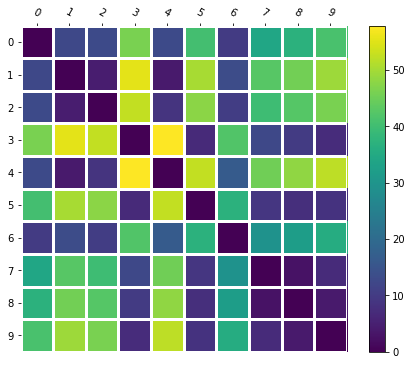

In [ ]:
vizutils.heatmap(dists, range(len(test)), range(len(test)));

Now, when we change the notion of distance by rescaling the features to same mean and variance, the distance plot looks totally different.

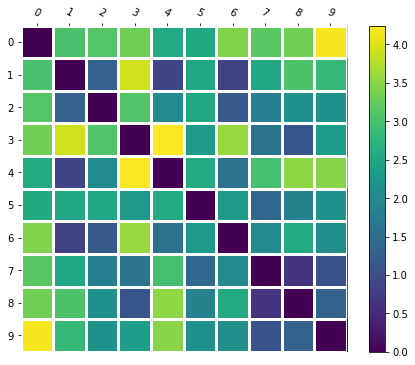

In [ ]:
dists = cdist(scaled, scaled)
vizutils.heatmap(dists);

The two distributions are clearly different.
It is a bit difficult to grasp all the movements but we can observe two examples.
The couples (0, 1) and (0, 6) were very close in the first graph, while they are now among the furthest.

In the context of UMAP, il will have a profund impact.
Because the distribution of distances between two points changes, the neigbhors will not be the same for a given point.
With different neigbors, UMAP will have very different constraints and will give very different embeddings.

Let's look at a somewhat extreme case.
We will perform UMAP directly on all the numeric columns of the breast cancer dataset.
__This is precisely what I recommend not to do.__

In [ ]:
raw = pd.read_parquet(ROOTDIR / 'data' / 'interim' / 'breast_cancer.parquet').reset_index()
test = raw.select_dtypes('number')
test.shape

(569, 31)

/mnt/c/Users/christophe_goudet/Documents/dev/esilv/venv/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


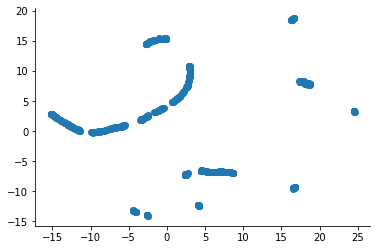

In [ ]:
from umap import UMAP
red = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=20)

transformed = red.fit_transform(test)
fig, ax = plt.subplots()
ax.scatter(transformed[:,0], transformed[:,1]);

Let's compare it with the same UMAP but with scaled features.

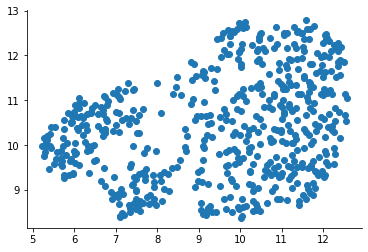

In [ ]:
from umap import UMAP

red = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=20)

transformed1 = red.fit_transform(scaler.fit_transform(test))
fig, ax = plt.subplots()
ax.scatter(transformed1[:,0], transformed1[:,1]);

We changed the normalisation of all features and the result were extremely different.
In the first situation we had a number of well defined clusters and patterns while in the second case the situation is less clear.

Usually there is no wrong or correct answer. 
The analyst can create an infinite number of embeddings by changing the role played by each variables.
The important point is to find informative emmbeddings.

**Interpretation**

Once an embedding has been computed, it is then necessary to understand why some points are at a specific place while others are at a different place.
Then we are back to lesson 1. 
Select the instances which belong to a specific region and try to see what they have in common.
Compare them to instances far from this region and find out in what they differ.
Here we will just present a simple analysis.
The point of the dataset was to predict wether the described cancer cells are benign ro malingrant.
Let's compare the two embeddings with respect to this variable.

In [ ]:
mask = raw.diagnosis=='M'

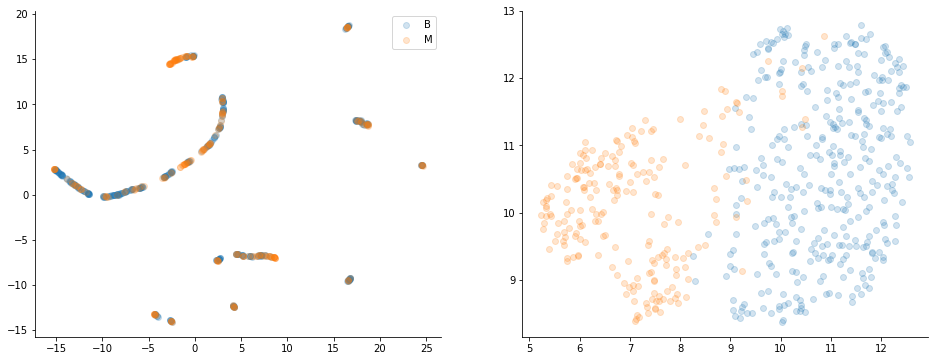

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))
opts = dict(alpha=0.2)
ax0.scatter(transformed[~mask,0], transformed[~mask,1], label='B', **opts)
ax0.scatter(transformed[mask,0], transformed[mask,1] ,label='M', **opts)

ax1.scatter(transformed1[~mask,0], transformed1[~mask,1], label='B', **opts)
ax1.scatter(transformed1[mask,0], transformed1[mask,1] ,label='M', **opts)
ax0.legend();

In this particular case we see that the very nice clusters we have in the first plot are not oriented with respect to diagnosis. 
For this particular case, the well defined custers are of no use.
Instead, we see that the second embeddings are much more meaningfull with respect to diagnosis, even though there is no well defined cluster.
It seems that all malingrant cancer cells are close of each other in the space of scaled variables.
UMAP has then found an embedding that puts benign cells on one side and the malign on the other.
This is an extremely informative embedding with respect to this task.

**Features**

I already mentionned that the first strategy was ill advised because it did not consider the scaling between all variables.
Students must be careful not to think that the second one is much better.
In this second situation, another major mistake was made : not considering which variables were included.
In both situation, we took all the variables which were not categorical.
In practice, there may be many columns which are categorical and very informative.
The analyst may then think how to encode categorical variables in order to integrate them in the embedding.
Then, no attention was given to the meaning of the selected variables.
Numerical variables are not always related to a measurement, they can be used in a wide variety of purposes.

For example, integer can be used specifically to represent categorical variable.
Then, does it make sense that instance with category 20 is 4 times further away to instance with category 1 than instance of category 15.
In other word, does it have sense to say that a person with brown eyes is two times more different from a person with blue eyes than a person with green eyes just because this information is encoded as 0, 2 and 1?

Integer can also bu used to represent an index : a unique value wich represent each instance.
Often, the fact that one instance has a value and another instance has another value has no meaning.
The indexes could be shuffled and nothing would really change in the dataset.
Then, it would be nonsense to use this type of variables into the embedding.

Here we have made this mistake : we used the column ```id``` for the embedding, which is exactly the arbitrary index of the instance.
Then we integrated the fact that an instance at the beginning of the dataset has less chances to be neighbour to an instance at the end of the dataset than at the middle.
Let's check if the embedding changes if we remove this column.

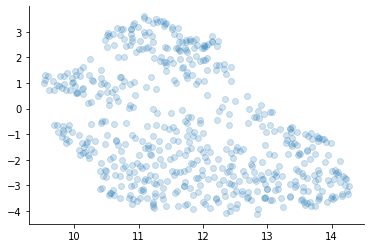

In [ ]:
from umap import UMAP

red = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=20)

transformed1 = red.fit_transform(scaler.fit_transform(test.drop(columns=['id'])))
np.save( ROOTDIR / 'data' / 'interim' / 'embedding_cancer.npy', transformed1)

fig, ax = plt.subplots()
ax.scatter(transformed1[:,0], transformed1[:,1], **opts)
fig.savefig(ROOTDIR / 'figures' / 'cancer_embedding.png');

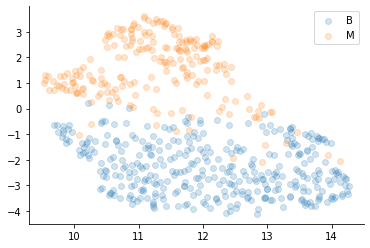

In [ ]:
fig, ax = plt.subplots()
ax.scatter(transformed1[~mask,0], transformed1[~mask,1], label='B', **opts)
ax.scatter(transformed1[mask,0], transformed1[mask,1] ,label='M', **opts)
ax.legend()
fig.savefig(ROOTDIR / 'figures' / 'cancer_embedding_diagnosis.png')

This new embedding is slightly changed with respect to the previous one.
First, because we removed a column, there are some instances that used to be neighbours and that are not anymore, and inversely.
This means the neighbourhood graph is sligthly different, hence leading to a slightly different embedding.

The second point worth mentionning is that the change is very minimal and nothing really changed, even though we have removed a column which introduced noise.
Because we scaled the dataframe, all columns have the same contribution to the total distance between two points.
Then, the impact of a single variable can be counter-balanced by the other.

Consider that the first and last points are identical (except for their id).
They will be at a distance of around 4.
Then imagine the first and second point, which have basically the same id but are 1 standard deviation away from each other in half of the variables.
Given that we have about 30 variables, these two points would be at a distance of $1^2*15=15$, hence much further away than the first and last points.
Finally, if we had fewer meaningful columns, or more meaningless columns, the results would have been very different.

### Why even reduce ?
 
One non intuitive usage of UMAP is to not reduce the dimension.
Instead it can be used to create an embedding of the same dimension of the data.
This seems to be a trivial problem, give a point the same coordinates in the initial space and in the embedding.
But what happens if you slightly change some points? Or if you start from random embeddings?

Here, we will create a dataset containing two clusters of different densities and look how UMAP will transform them.

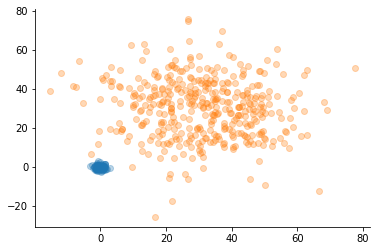

In [ ]:
from sklearn.datasets import make_blobs
from src.visualization.utils import *
data, labels = make_blobs(n_samples=[100, 400], 
                          random_state=12,
                         centers = [[0, 0], [30, 30]], 
                         cluster_std=[1, 15])
fig, ax = plt.subplots()
for label in np.unique(labels):
    mask = labels==label
    ax.scatter(data[mask,0], data[mask,1], alpha=0.3)

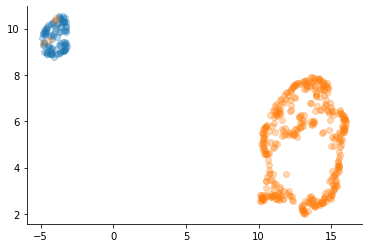

In [ ]:
red = UMAP(n_neighbors=len(data)-1, min_dist=0.1, n_components=2, random_state=20)
transformed = red.fit_transform(red.fit_transform(data))

fig, ax = plt.subplots()
for label in np.unique(labels):
    mask = labels==label
    ax.scatter(transformed[mask,0], transformed[mask,1], alpha=0.3)

So what happened?

We have seen in the definition of UMAP that it first create distances between neighbors.
We see that a couple orange points seem closer to the blue cluster than to other orange points.
Otherwise, most blue and orange points will be tighly related only to other points of the same color.
Because of that, there is little incentive for UMAP to try to bring those clusters together.
Instead, it understand that this is two communities and separate them.

Then we observe that the blue cluster has been expanded a bit and that the orange has been severly reduced.
This is because how UMAP treat distances under the hood.
In the blue cluster, the distance between two neigbours are exremely small.
Inversely, the distance between neighbours is much larger in the orange cluster.
However, the mathematical theorem on which UMAP relies needs those distances to be similar.
The UMAP algorithm will then change locally the notion of distance so that the distance between a point and its closest neighbours is always 1.
This means that the distance that UMAP tries to replicate in the embedding is not the inital distance but one locally modified.
Under this new distance, both clusters have roughly the same size.

We have seen that even if we provide UMAP with all the right distances, everything is distorded.
Let's look at what happens when we provide UMAP with more realistic parameters.
Because the data is randomly generated, there will be spots where there will be a bit more data than expected, and spots more desert.
UMAP will see those more densly populated area and identify them as clusters.
It may then create subclusters in the orange population.

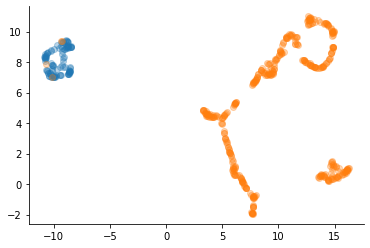

In [ ]:
red = UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=20)
transformed = red.fit_transform(red.fit_transform(data))

fig, ax = plt.subplots()
for label in np.unique(labels):
    mask = labels==label
    ax.scatter(transformed[mask,0], transformed[mask,1], alpha=0.3)

In this example, we have seen how we can leverage UMAP to highlight the dense regions of the dataset and separate what seem to be clusters.
However, the clusters will be very deformed, so nothing is to be expected from the form the the clusters.
They will be defined only by various continuous shapes.

## dimension reduction for variable selection

Dimension reduction is always used in the same way.
You have a dataset of $n$ lines and $k$ columns and you try to reduce to a dataset of $n$ lines and $2$ columns.
In this section, we will show another way of leveraging this type of algorithm by performing a very simple action : take the transpose of the dataset.

In [ ]:
test = raw.drop(columns=['id', 'diagnosis']).copy()
test.T

0            1            2           3    \
radius_mean                17.990000    20.570000    19.690000   11.420000   
texture_mean               10.380000    17.770000    21.250000   20.380000   
perimeter_mean            122.800000   132.900000   130.000000   77.580000   
area_mean                1001.000000  1326.000000  1203.000000  386.100000   
smoothness_mean             0.118400     0.084740     0.109600    0.142500   
compactness_mean            0.277600     0.078640     0.159900    0.283900   
concavity_mean              0.300100     0.086900     0.197400    0.241400   
concave points_mean         0.147100     0.070170     0.127900    0.105200   
symmetry_mean               0.241900     0.181200     0.206900    0.259700   
fractal_dimension_mean      0.078710     0.056670     0.059990    0.097440   
radius_se                   1.095000     0.543500     0.745600    0.495600   
texture_se                  0.905300     0.733900     0.786900    1.156000   
perimeter_se                8.589000     3.398000     4.585000    3.445000   
area_se                   153.400000    74.080000    94.030000   27.230000   
smoothness_se               0.006399     0.005225     0.006150    0.009110   
compactness_se              0.049040     0.013080     0.040060    0.074580   
concavity_se                0.053730     0.018600     0.038320    0.056610   
concave points_se           0.015870     0.013400     0.020580    0.018670   
symmetry_se                 0.030030     0.013890     0.022500    0.059630   
fractal_dimension_se        0.006193     0.003532     0.004571    0.009208   
radius_worst               25.380000    24.990000    23.570000   14.910000   
texture_worst              17.330000    23.410000    25.530000   26.500000   
perimeter_worst           184.600000   158.800000   152.500000   98.870000   
area_worst               2019.000000  1956.000000  1709.000000  567.700000   
smoothness_worst            0.162200     0.123800     0.144400    0.209800   
compactness_worst           0.665600     0.186600     0.424500    0.866300   
concavity_worst             0.711900     0.241600     0.450400    0.686900   
concave points_worst        0.265400     0.186000     0.243000    0.257500   
symmetry_worst              0.460100     0.275000     0.361300    0.663800   
fractal_dimension_worst     0.118900     0.089020     0.087580    0.173000   

                                 4           5            6           7    \
radius_mean                20.290000   12.450000    18.250000   13.710000   
texture_mean               14.340000   15.700000    19.980000   20.830000   
perimeter_mean            135.100000   82.570000   119.600000   90.200000   
area_mean                1297.000000  477.100000  1040.000000  577.900000   
smoothness_mean             0.100300    0.127800     0.094630    0.118900   
compactness_mean            0.132800    0.170000     0.109000    0.164500   
concavity_mean              0.198000    0.157800     0.112700    0.093660   
concave points_mean         0.104300    0.080890     0.074000    0.059850   
symmetry_mean               0.180900    0.208700     0.179400    0.219600   
fractal_dimension_mean      0.058830    0.076130     0.057420    0.074510   
radius_se                   0.757200    0.334500     0.446700    0.583500   
texture_se                  0.781300    0.890200     0.773200    1.377000   
perimeter_se                5.438000    2.217000     3.180000    3.856000   
area_se                    94.440000   27.190000    53.910000   50.960000   
smoothness_se               0.011490    0.007510     0.004314    0.008805   
compactness_se              0.024610    0.033450     0.013820    0.030290   
concavity_se                0.056880    0.036720     0.022540    0.024880   
concave points_se           0.018850    0.011370     0.010390    0.014480   
symmetry_se                 0.017560    0.021650     0.013690    0.014860   
fractal_dimension_se        0.005115    0.005082     0.002179    0.005412 

Let's now consider this as any other dataset.
We have 33 instances for which we have 569 columns.
This is a situation that can happen in many fields where measuring one instance is costly but generate a lot of properties.
Gene datasets belong to this category.

Let's assume that our initial dataset was normalised.
With the normalisation, the value of a given feature is related to the position of the patient with respect to the other.
If the features has a normal distribution, a value of 2 means that this patient has a value among the top $5\%$, while a value below -1 means bottom $15\%$.
Then, with a distance, we can loook at variables which have a tendency to put patients at the same ranking.
In some way, this is a level of correlation.

But what happen if variables are perfectly anticorrelated?
Then the distance between those two variables will have a tendency to be far away.
However, dimension reduction aims at grouping together instances that are close together.
So if two variables are perfect opposite, they will be far away even though they are closely related.
This may be perfectly fine for some usage.
In the case of correlation, we wish to find variables that are related, even in an opposite manner.
Then we can just add the opposite of the anticorrelated features, which then will be very close the reference feature.

In [ ]:
for c in test.columns:
    test['min_'+c] = - test[c]

In [ ]:
scaled = scaler.fit_transform(test).T
scaled.shape

(60, 569)

Exactly like before, we can compute the distance between any pair of instances (formerly features) and see of some seem closer to each other.
In this case, there soesn't seem to be any close relation between a variable and the minus of another one.

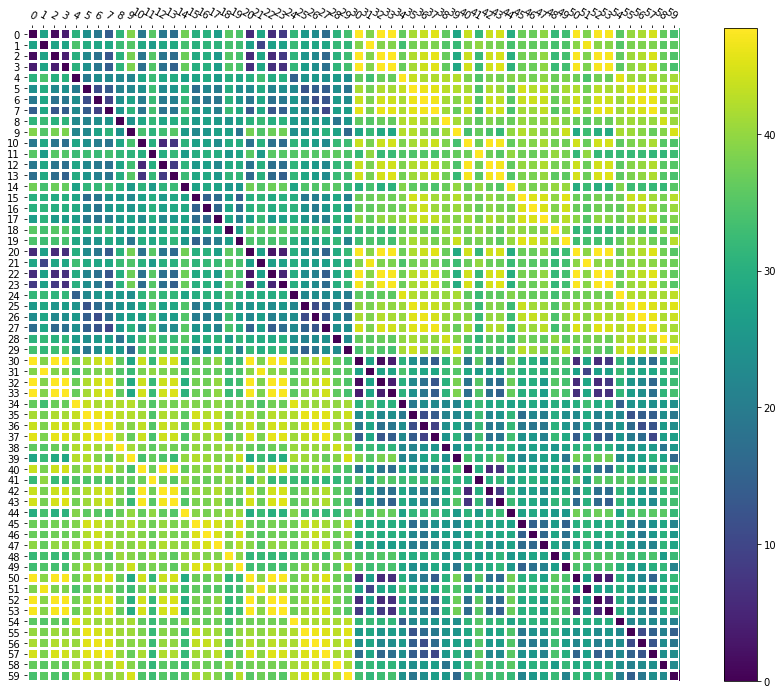

In [ ]:
dists = cdist(scaled, scaled)
vizutils.heatmap(dists, range(len(scaled)), range(len(scaled)), figsize=(16, 12));

With such a graph, it is complicated to see if there are groups of variables particularly close together, unless we are lucky enough that they are positionned close together in the list of columns.
This problem also happen for regular correlation.
It would be much better to have a 2D plot were variables highly correlated are close to each other, and removed from the ones without correlation.
Then, why not use this table of distances and apply UMAP to find such a representation.

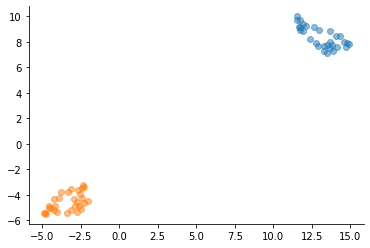

In [ ]:
red = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=20)
mask = np.arange(len(scaled))<len(scaled)/2

transformed = red.fit_transform(scaled)
fig, ax = plt.subplots()
ax.scatter(transformed[mask,0], transformed[mask,1], label='initial', alpha=0.5)
ax.scatter(transformed[~mask,0], transformed[~mask,1], label='opposite', alpha=0.5);

In this experiment we see that adding the opposite variables have not brough much to the problem.
As we have seen from the previous graph, variables seems mainly positively correlated between each other.

We also see from this graph that UMAP has created a structure in each group to put the features on.
Because we have added the opposite of each feature, we even have two different embedding for the same relations.
This can help us estimate which variables are closest in term of behaviour.

In this example, we used the default euclidian metric, which we have shown may have trouble with respect to anticorrelation.
But we also said that UMAP can use any metric, because in practices it just requires the matrix of distances between instances.
What if we use directly the correlation as a distance?

Two variables which are perfectly identical will have a correlation of 1, which should match a 0 distance.
With less correlation, the distance should increase.
But then, it would be nice if highly anticorrelated variables had a very low distance between each other.
Then, we can use the following expression as a distance between features.

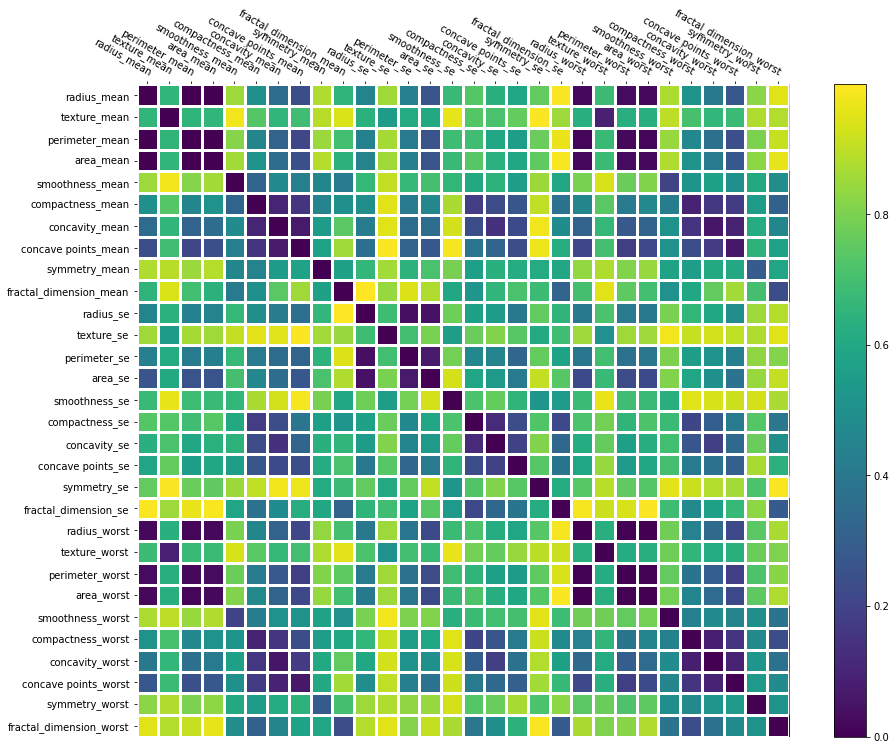

In [ ]:
from scipy.stats import *
test = raw.drop(columns=['id', 'diagnosis'])
corr, _ = spearmanr(test)
dists = 1 - np.abs(corr)
vizutils.heatmap(dists, list(test.columns), list(test.columns), figsize=(16, 12));

We can then tell UMAP to directly consider the input data as the distance matrix.
This allows to create an embedding but it will be impossible to use it on new data.

/mnt/c/Users/christophe_goudet/Documents/dev/esilv/venv/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


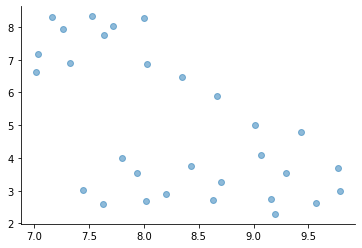

In [ ]:
red = UMAP(metric='precomputed', n_neighbors=10, min_dist=0.1, n_components=2, random_state=20)

transformed = red.fit_transform(dists)
fig, ax = plt.subplots()
ax.scatter(transformed[:,0], transformed[:,1], alpha=0.5);

So far we have seen multiple examples using UMAP.
However, the presented techniques are not related to this particular dimension reduction technique.
The code below show how to apply PCA on the transpose of the dataset.
Because the algorithm works differently, we see that the embedding is very different.
In particular, there is a cluster of 7 features that seem close together.
This would need further reseach to better understand those variables.

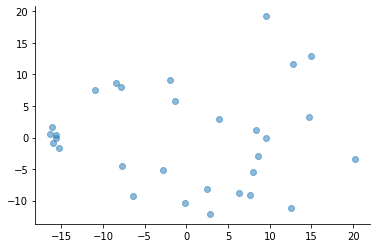

In [ ]:
pca = PCA(2)
scaled = scaler.fit_transform(test).T
transf = pca.fit_transform(scaled)
fig, ax = plt.subplots()
ax.scatter(transf[:,0], transf[:,1], alpha=0.5);

## Conclusion

In this lesson, we covered multiple techniques in the field of dimension reduction.
This field aims at finding a low dimension representation of a high dimensionnal dataset while keeping a maximum of information.
We presented two popular techniques.

* PCA is a technique inspired by linear algebra which aim at finding a set of axes on which to project the data, while retaining a maximum of the variance of the data.

* UMAP is a technique that aims to reproduce in lower dimension the relative distances between close neighbors. For this particular technique, we have seen the level of control that the analyst can have, mainly through the definition of the metric to use.


This lesson was also an opening to the use of dimension reduction algorithms in non standard ways.
In this example, we used it to propose a visualisation of the similarity between variables.

## Exercice

### Similar medicine

In this exercice, we wish to identify medicine prescribed in similar situation.
For this purpose, we want to create a 2D embedding of medicines.
Identify how you can describe each medicine in high dimension, and apply dimension reduction on it.

### Similar patients
We have observed during the course on missing values that the patient dataset has many missing values, and that some missing values are correlated.
We have assumed that features are related to a set of symptoms or medical exam.
Apply dimension reduction on the binary variables of missing values to identify similar patients.

### Correlation

In the correlation course, we have seen two ways to estimate how variables are related.
Identify how dimension reduction algorithms can also be used as a different measure of correlation.
Apply the technique to the cancer dataset.

As a second step, imagine how the traditionnal correlation measures can be used as a distance metric for an algorithm.
Compare this strategy to the first one.